In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import root
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

In [2]:
df = pd.read_csv("./data/course_lead_scoring.csv")

In [3]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
categorical_features = df.columns[(df.dtypes == "object").values].to_list()
numerical_features = df.columns[(df.dtypes != "object").values].to_list()

In [5]:
for c in categorical_features:
    df[c] = df[c].fillna("NA")
for c in numerical_features:
    df[c] = df[c].fillna(0.0)

In [6]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
numerical_features.pop()

'converted'

In [8]:
def train_test_val_split(
    df: pd.DataFrame,
    val_frac: float = 0.2,
    test_frac: float = 0.2,
    random_state: int = 42,
    target_var: str = "y",
):
    """Perform train,validation,test split. Returns data frames of predictors and
    and arrays of targets for train,validation and test.

    Args:
        df (pd.DataFrame): The raw data
        val_frac (float, optional): The fraction of total to use for validation.
            Defaults to 0.2.
        test_frac (float, optional): The fraction of total to use for test.
            Defaults to 0.2.
        random_state (int, optional): The random state. Defaults to 42.
        target_var (str,optional): The target variable. Defaults to y.
    Returns:
        tuple: (df_train,df_val,df_test,y_train,y_val,y_test)
    """
    df_full_train, df_test = train_test_split(
        df, test_size=test_frac, random_state=random_state
    )
    df_train, df_val = train_test_split(
        df_full_train, test_size=val_frac / (1 - test_frac), random_state=random_state
    )

    y_train = df_train[target_var]
    y_val = df_val[target_var]
    y_test = df_test[target_var]

    df_train = df_train.drop(columns=[target_var])
    df_val = df_val.drop(columns=[target_var])
    df_test = df_test.drop(columns=[target_var])

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [9]:
df_train, df_val, df_test, y_train, y_val, y_test = train_test_val_split(
    df, target_var="converted"
)

# Question 1

In [10]:
numerical_features = df_train.columns[(df_train.dtypes != "object").values].to_list()
categorical_features = df_train.columns[(df_train.dtypes == "object").values].to_list()

In [11]:
scores = []
for f in numerical_features:
    auc_score = roc_auc_score(y_train, df_train[f])
    if auc_score < 0.5:
        # Note that we can get the auc_score for negatively correlated
        # vars just by subtracting the score from 1
        check = 1 - auc_score
        # Invert directly
        auc_score = roc_auc_score(y_train, -df_train[f])
        # Check they are equal to numerical precison
        np.testing.assert_almost_equal(auc_score, check, decimal=14)
    scores.append(auc_score)
df_sc = pd.DataFrame(zip(numerical_features, scores), columns=["Feature", "AUC"])

In [12]:
df_sc

,Feature,AUC
0,number_of_courses_viewed,0.755011
1,annual_income,0.529092
2,interaction_count,0.719617
3,lead_score,0.630443


`number_of_courses_viewed` has the highest AUC

# Question 2

In [13]:
def train_logistic_regression(
    df_train: pd.DataFrame, y_train: pd.Series, random_state: int = 1, C: float = 1.0
):
    """Train a logistic regression model on the data. Performs one-hot
    encoding for all categorical vars.

    Args:
        df_train (pd.DataFrame): The training predictors
        y_train (pd.Series): The target variable
        random_state (int, optional): Random state to use. Defaults to 1.
        C (float, optional): Regularization parameter. Defaults to 1.0.

    Returns:
        tuple: DictVectorizer,trained model
    """
    train_dicts = df_train.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    model = LogisticRegression(
        solver="liblinear", C=C, max_iter=1000, random_state=random_state
    )
    model.fit(X_train, y_train)
    return dv, model


def predict(
    dv: DictVectorizer, model: sklearn.base.BaseEstimator, df: pd.DataFrame
) -> np.ndarray:
    dicts = df.to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [14]:
dv, model = train_logistic_regression(df_train, y_train, random_state=1)
y_pred = predict(dv, model, df_val)
auc_score = roc_auc_score(y_val, y_pred)

In [15]:
np.round(auc_score, 3)

np.float64(0.855)

# Question 3

In [16]:
thresholds = np.linspace(0, 1, 100, endpoint=False)

In [17]:
def compute_precision_recall(
    y_true: np.ndarray, y_pred: np.ndarray, thresholds: np.ndarray
) -> pd.DataFrame:
    """Computes precision and recall (along with tp,fp,tn,fn) based on
    the true labels, the predicted probabilities and an array of
    thresholds.

    Args:
        y_true (np.ndarray): The true labels (must be either 0 or 1)
        y_pred (np.ndarray): The predicted probabilities (must be in [0,1])
        thresholds (np.ndarray): The array of thresholds (must be in [0,1))

    Returns:
        pd.DataFrame: The dataframe with results
    """
    scores = []
    actual_positive = y_true == 1
    actual_negative = y_true == 0
    for t in thresholds:

        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=["t", "TP", "FP", "FN", "TN"])
    recall = df_scores.TP / (df_scores.TP + df_scores.FN)
    precision = df_scores.TP / (df_scores.TP + df_scores.FP)
    df_scores["precision"] = precision
    df_scores["recall"] = recall
    return df_scores

In [18]:
df_pr = compute_precision_recall(y_val, y_pred, thresholds)

In [19]:
def compute_intersection(t: np.array, p: np.array, r: np.array) -> float:
    """Compute the approximate intersection of the precision and recall
    curves, represented as arrays sampled at different thresholds t.
    This is done by interpolating both precision and recall as cubic splines
    and then solving numerically the equation p(t)-r(t) = 0.

    Args:
        t (np.array): The array of thresholds
        p (np.array): The precision values
        r (np.array): The recall values

    Returns:
        float: The intersection point
    """
    intrp_p = InterpolatedUnivariateSpline(t, p)
    intrp_r = InterpolatedUnivariateSpline(t, r)

    def obj_func(t):
        return intrp_p(t) - intrp_r(t)

    res = root(obj_func, x0=0.7)
    # Check the numerical root finding has converged
    # assert res.success, "The numerical solution has failed to converge!"
    return res.x[0]

In [20]:
idx = df_pr["precision"].isna()
x_intercept = compute_intersection(
    df_pr.t.values[~idx], df_pr.precision.values[~idx], df_pr.recall.values[~idx]
)

In [21]:
intrp = InterpolatedUnivariateSpline(df_pr.t.values, df_pr.precision.values)

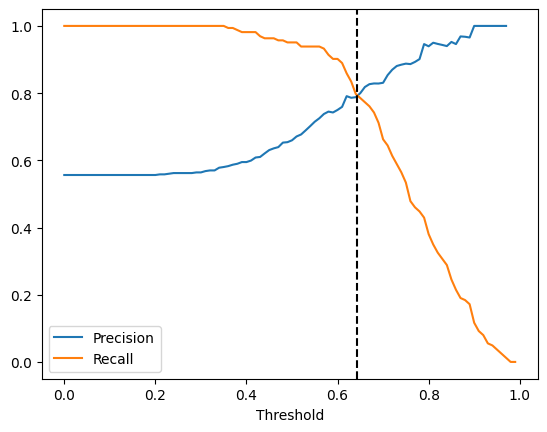

In [22]:
plt.plot(df_pr.t, df_pr.precision, label="Precision")
plt.plot(df_pr.t, df_pr.recall, label="Recall")
plt.axvline(x=x_intercept, ls="--", color="k")
plt.xlabel("Threshold")
plt.legend(loc="best")

In [23]:
print(f"The intersection of the curves is at {np.round(x_intercept,3)}")

The intersection of the curves is at 0.643


# Question 4

In [24]:
def compute_f1_score(p, r):
    return 2 * p * r / (p + r)

In [25]:
f1_scores = compute_f1_score(df_pr[~idx].precision.values, df_pr[~idx].recall.values)

In [26]:
crude_max = df_pr[~idx].t.iloc[f1_scores.argmax()]

Text(0, 0.5, '$F_{1}$')

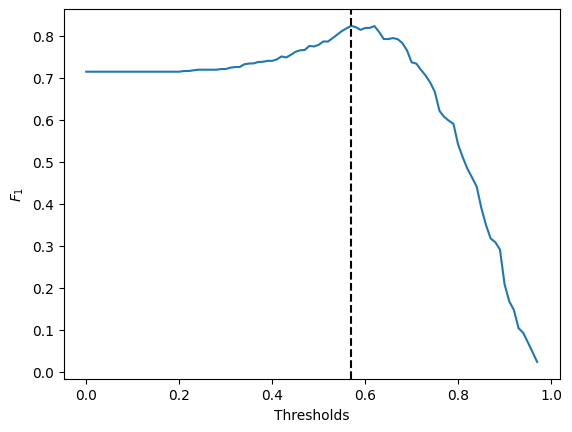

In [27]:
plt.plot(df_pr[~idx].t, f1_scores)
plt.axvline(x=crude_max, ls="--", color="k")
plt.xlabel("Thresholds")
plt.ylabel(r"$F_{1}$")

In [28]:
crude_max

np.float64(0.5700000000000001)

# Question 5

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
df_full_train = pd.concat((df_train, df_val))
y_full_train = np.concatenate((y_train, y_val))

In [30]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train_logistic_regression(df_train, y_train)
    y_pred = predict(dv, model, df_val)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [31]:
scores = np.array(scores)

In [32]:
np.std(scores)

np.float64(0.007529650176121231)

# Question 6

In [33]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train_logistic_regression(df_train, y_train, C=C)
        y_pred = predict(dv, model, df_val)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f"C={C}, AUC = {np.round(np.mean(scores),3)}±{np.round(np.std(scores),3)}")

100%|██████████| 3/3 [00:00<00:00, 25.64it/s]

C=1e-06, AUC = 0.542±0.042
C=0.001, AUC = 0.87±0.013
C=1, AUC = 0.827±0.008


Thus C=0.001 gives the best AUC score